# Metadata

```yaml
Course:    DS 5001
Module:    09 Lab
Topic:     Word2Vec
Author:    R.C. Alvarado
Date:      27 March 2024 (revised)
```

**Purpose:** We create word embeddings with novel data using word2vec and visualize results with tSNE.

# Set Up

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
# Adjust this for a new corpus
data_prefix = 'novels'
table_dir =  f'{data_home}/{data_prefix}'
OHCO = ['book', 'chapter', 'para_num', 'sent_num', 'token_num']
PARA = OHCO[:4] # Paragraphs
SENT = OHCO[:5] # Sentences
BAG = PARA
# BAG = SENT

In [3]:
# word2vec parameters
w2v_params = dict(
    window = 5,
    vector_size = 246,
    min_count = 50, # THIS LIMITS OUR VOCAB
    workers = 4
)

In [4]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE as tsne
import plotly_express as px

In [5]:
import gensim
gensim.__version__

'4.0.1'

# Import `TOKENS` and `VOCAB`

We import data from the TOKEN table of the novels corpus, excluding proper nouns.

In [6]:
TOKENS = pd.read_csv(f'{table_dir}/{data_prefix}-TOKENS.csv').set_index(OHCO)

In [7]:
TOKENS.head()

pos     term_str  term_id
book            chapter para_num sent_num token_num                           
secretadversary 1       0        1        0           DT          the    24127
                                          1          NNP        young    27354
                                          2          NNP  adventurers      399
                                          3          NNP          ltd    14406
                        1        0        0           JJ        tommy    24529

In [8]:
VOCAB = pd.read_csv(f'{table_dir}/{data_prefix}-VOCAB.csv').set_index('term_str')

In [9]:
VOCAB = VOCAB[~VOCAB.index.isna()] # There is NaN in the index for some reason

In [10]:
VOCAB.sample(5)

,term_id,tfidf_sum,n
term_str,,,
spoke,22640,0.017060,538
excursions,8634,0.001557,7
purse,18980,0.006477,26
disrespectfully,7080,0.001780,4
steepest,22903,0.000353,1


In [11]:
VOCAB['pos_max'] = TOKENS.groupby(['term_str','pos']).pos.count().unstack().idxmax(axis=1)

In [12]:
VOCAB

,term_id,tfidf_sum,n,pos_max
term_str,,,,
a,0,0.000000,28533,DT
aback,1,0.003732,9,NN
abaft,2,0.000876,2,IN
abandon,3,0.006993,44,VB
abandoned,4,0.010044,68,VBN
...,...,...,...,...
à,27392,0.001965,3,NNP
æt,27393,0.000438,1,NN
ætat,27394,0.000696,1,VBD


# Convert to Gensim

We now create a Gensim-style corpus of docs, a list of lists of tokens.

In [13]:
# TOKENS

In [14]:
docs = TOKENS[~TOKENS.pos.str.match('NNPS?')].dropna(subset=['term_str'])\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1] # Lose single word docs

In [15]:
print(docs[:2])

[['to', 'she', 'is', 'always', 'woman'], ['i', 'have', 'seldom', 'heard', 'him', 'mention', 'her', 'under', 'any', 'other', 'name']]


In [16]:
vocab = Dictionary(docs)

# Generate word embeddings with Gensim's module

In [17]:
model = word2vec.Word2Vec(docs, **w2v_params)

In [18]:
model.wv.vectors

array([[-0.41655567,  0.13069312,  0.37012297, ...,  0.12406031,
        -0.07241014,  0.17935042],
       [ 0.25970033, -0.6662276 , -1.2682118 , ..., -0.08696964,
         0.4695251 ,  0.13872649],
       [-0.14654443, -0.74601835,  0.2243035 , ..., -0.31192005,
         0.45797583, -0.22950035],
       ...,
       [ 0.05621757, -0.09294613, -0.09250345, ..., -0.14196824,
        -0.00462891,  0.15804824],
       [-0.0587926 , -0.00536617,  0.06003612, ...,  0.08069236,
         0.3296725 , -0.04755132],
       [ 0.00782941, -0.14115287, -0.03011556, ...,  0.09500048,
         0.05099777, -0.01815401]], dtype=float32)

# Visualize with tSNE

## Convert model to data frame

In [20]:
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        vec = None
    return vec

In [21]:
WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)

In [22]:
WV

,0,1,2,3,4,5,6,7,8,9,...,236,237,238,239,240,241,242,243,244,245
term_str,,,,,,,,,,,,,,,,,,,,,
a,-0.662410,-0.147297,0.589964,0.957361,-0.542414,-0.219752,-0.455766,-0.349395,-0.586978,0.263674,...,-0.513418,0.192911,-0.145941,0.327150,-0.130962,0.042039,0.085509,0.256450,-0.274021,-0.918686
abandoned,-0.018878,0.002918,0.051238,0.042291,-0.134178,-0.045668,-0.326341,-0.168181,-0.191665,-0.178562,...,-0.014673,0.034017,-0.116812,-0.147888,0.205609,0.050050,0.099322,0.066387,-0.007958,0.027421
abbess,0.043773,-0.004874,-0.025217,0.036742,0.063107,-0.007904,-0.041555,-0.100168,0.043050,0.006701,...,0.076343,0.095253,0.018961,0.043625,0.046764,0.093125,0.065309,0.064077,0.092362,0.026631
able,-0.181982,-0.963943,0.021145,0.044137,0.098226,-0.272964,-0.274638,-0.100731,0.229520,0.132163,...,-0.166238,0.510473,0.014442,0.006910,-0.032070,0.264445,-0.262442,0.022401,-0.000742,0.028293
about,-0.678579,-0.615795,-0.683538,-0.024278,0.143821,-0.494719,-1.699358,-0.542123,-0.899471,-0.048688,...,0.279790,-0.263825,0.112019,-0.243659,-0.025485,0.324488,0.203849,-0.086958,-0.005250,0.177169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
youre,0.126198,0.036175,-0.171317,0.043373,-0.035509,-0.048741,-0.422213,0.018248,-0.159962,0.058636,...,0.070582,0.218200,-0.338207,0.124121,-0.239210,-0.188202,-0.200487,0.267109,-0.145612,0.157860
yours,-0.137476,-0.198403,0.205852,0.026435,-0.097330,0.094404,-0.478604,-0.324696,0.084733,0.065646,...,-0.030535,0.051237,-0.018991,0.261969,-0.189662,0.184760,-0.128842,0.119871,-0.318966,-0.076080
yourself,-0.199592,-0.274070,-0.282478,-0.042043,0.359971,0.208035,-0.857710,-0.216914,0.442947,-0.071565,...,-0.049761,0.287217,-0.198783,0.320064,-0.270270,-0.198366,-0.267058,-0.067647,-0.595749,0.263528


## Use ScikitLearn's TSNE library

In [24]:
tsne_engine = tsne(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

In [25]:
tsne_model = tsne_engine.fit_transform(WV.to_numpy())

In [26]:
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)

In [27]:
TSNE

,x,y
term_str,,
a,-18.245470,24.490801
abandoned,-2.994510,-26.823982
abbess,-12.180204,-5.604848
able,9.400002,-29.635098
about,14.207968,-25.925449
...,...,...
youre,20.931818,-27.339766
yours,27.512152,-1.191198
yourself,49.111866,-1.267431


## Plot the coordinates

In [29]:
X = TSNE.join(VOCAB, how='left')

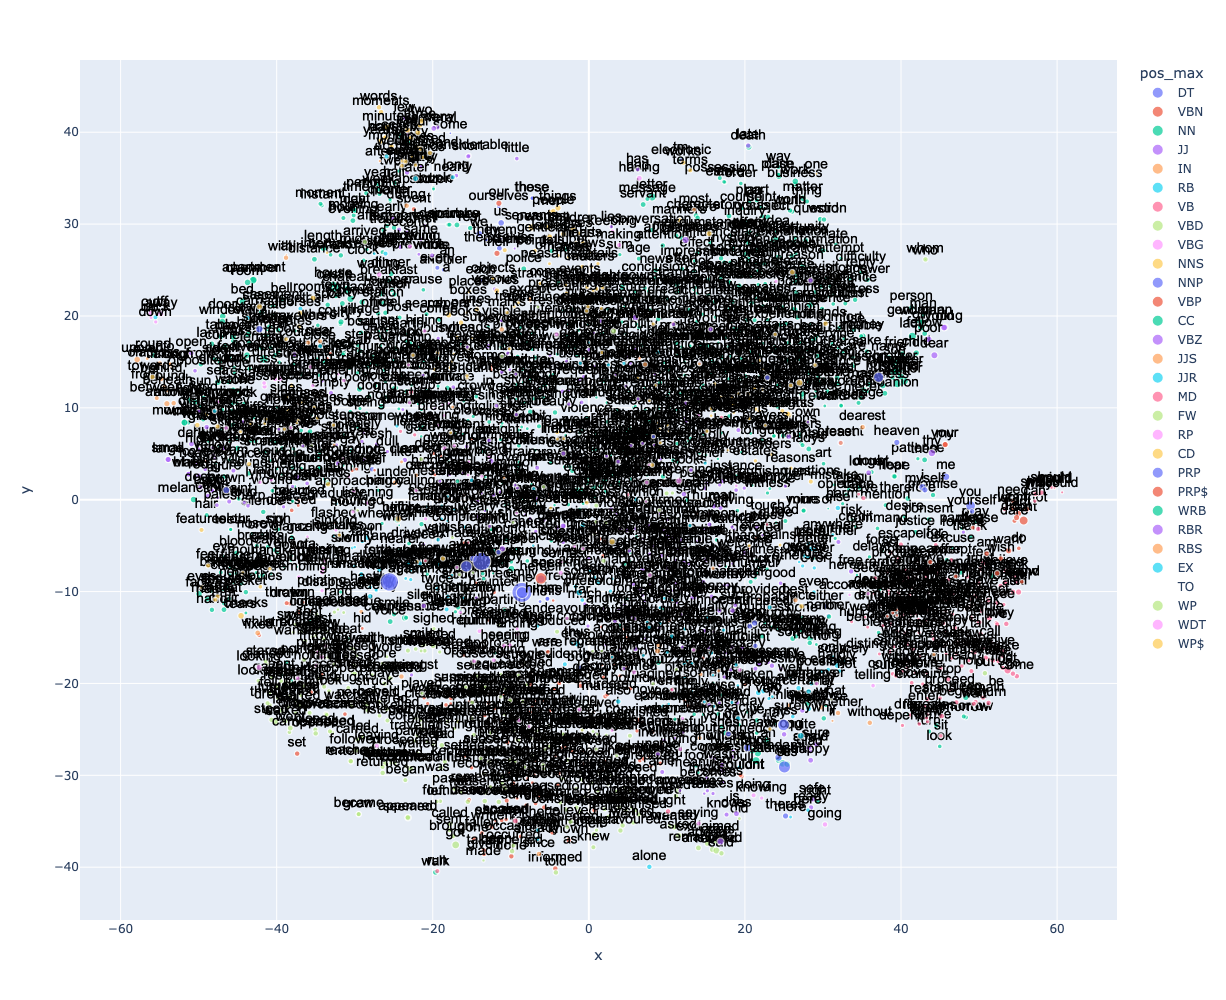

In [33]:
px.scatter(X.reset_index(), 'x', 'y', 
           text='term_str', 
           color='pos_max', 
           hover_name='term_str',          
           size='tfidf_sum',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

# Semantic Algebra

## Analogies

$A : B :: C : D? \rightarrow B - A + C = D$


In [34]:
def complete_analogy(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [35]:
complete_analogy('man', 'boy', 'woman', 3)

,term,sim
0,girl,0.761186
1,peasant,0.722295
2,lady,0.674678


In [36]:
complete_analogy('girl', 'daughter', 'boy', 3)

,term,sim
0,uncle,0.851150
1,wife,0.810062
2,brothers,0.809564


In [37]:
complete_analogy('girl', 'sister', 'boy', 3)

,term,sim
0,cousin,0.830355
1,uncle,0.804971
2,tongue,0.775073


In [38]:
complete_analogy('man', 'gentleman', 'woman', 5)

,term,sim
0,girl,0.820168
1,young,0.742144
2,lady,0.721437
3,peasant,0.719355
4,fellow,0.688670


In [39]:
complete_analogy('man', 'woman', 'gentleman', 5)

,term,sim
0,girl,0.820168
1,young,0.742144
2,lady,0.721437
3,peasant,0.719355
4,fellow,0.688670


In [40]:
complete_analogy('woman', 'man', 'lady', 5)

,term,sim
0,friend,0.704716
1,gentleman,0.692965
2,doctor,0.687790
3,girl,0.679898
4,servant,0.677405


In [41]:
complete_analogy('day', 'night', 'sun', 5)

,term,sim
0,twilight,0.830339
1,wind,0.821844
2,gates,0.798260
3,moon,0.795272
4,clouds,0.794780


In [42]:
complete_analogy('woman','answered','man', 5)

,term,sim
0,added,0.704786
1,said,0.697467
2,replied,0.688821
3,cried,0.671303
4,says,0.657439


In [43]:
complete_analogy('man','replied','woman', 5)

,term,sim
0,answered,0.732152
1,said,0.720780
2,added,0.694805
3,exclaimed,0.692846
4,oh,0.687086


In [44]:
complete_analogy('wife', 'appeared', 'husband', 5)

,term,sim
0,seemed,0.768458
1,proved,0.575921
2,believed,0.567640
3,considered,0.565698
4,served,0.547228


In [45]:
complete_analogy('husband', 'appeared', 'wife', 5)

,term,sim
0,seemed,0.656825
1,perceived,0.636583
2,concluded,0.630338
3,distinguished,0.603926
4,described,0.603773


In [46]:
complete_analogy('man', 'father', 'woman', 5)

,term,sim
0,mother,0.868081
1,aunt,0.830212
2,husband,0.807716
3,sister,0.777970
4,niece,0.768720


In [47]:
complete_analogy('man', 'husband', 'woman', 5)

,term,sim
0,mother,0.817473
1,aunt,0.796488
2,father,0.778949
3,niece,0.748530
4,sister,0.739437


In [48]:
complete_analogy('man', 'castle', 'woman', 5)

,term,sim
0,chateau,0.743686
1,house,0.730191
2,convent,0.728001
3,town,0.695872
4,neighbourhood,0.661600


In [49]:
complete_analogy('woman', 'home', 'man', 5)

,term,sim
0,rest,0.644972
1,off,0.632075
2,station,0.619529
3,dinner,0.596853
4,ready,0.583603


## Similarites

In [50]:
get_most_similar('joy')

,term,sim
0,horror,0.869370
1,delight,0.869118
2,grief,0.860102
3,anguish,0.859180
4,disgust,0.854160
5,admiration,0.852541
6,tenderness,0.846865
7,indignation,0.846535
8,awe,0.845681
9,emotions,0.844545


In [51]:
get_most_similar('man')

,term,sim
0,gentleman,0.842648
1,woman,0.831768
2,girl,0.756086
3,fellow,0.744837
4,creature,0.719356
5,person,0.691791
6,stranger,0.669861
7,peasant,0.669159
8,lady,0.637354
9,servant,0.610928


In [52]:
get_most_similar(positive=['man'], negative=['woman'])

,term,sim
0,off,0.350625
1,rest,0.349211
2,together,0.335758
3,up,0.315374
4,them,0.306318
5,us,0.304597
6,lie,0.301445
7,his,0.299725
8,down,0.286924
9,money,0.283216


In [53]:
get_most_similar(positive='woman')

,term,sim
0,girl,0.859558
1,gentleman,0.859198
2,man,0.831767
3,fellow,0.778859
4,creature,0.766056
5,peasant,0.751842
6,stranger,0.707724
7,lady,0.706671
8,young,0.690343
9,poor,0.674208


In [54]:
get_most_similar(positive=['woman'], negative=['man'])

,term,sim
0,particularly,0.435114
1,sweet,0.428298
2,young,0.403483
3,dying,0.399527
4,odd,0.384167
5,unhappy,0.375937
6,extremely,0.372431
7,relieved,0.365938
8,strongly,0.358301
9,beloved,0.357993


In [55]:
get_most_similar(['man','woman'],['boy','girl'])

,term,sim
0,human,0.503856
1,even,0.478855
2,nor,0.448182
3,real,0.432257
4,criminal,0.413341
5,or,0.406866
6,person,0.386927
7,doubted,0.382917
8,appeared,0.376169
9,evil,0.374240


# View with HAC

In [56]:
import sys
sys.path.append(local_lib)
from hac import HAC

In [57]:
WV2 = WV.join(VOCAB.pos_max)
WV2 = WV2[~WV2.pos_max.str.match(r"NNPS?")].iloc[:, :-1]

<Figure size 432x288 with 0 Axes>

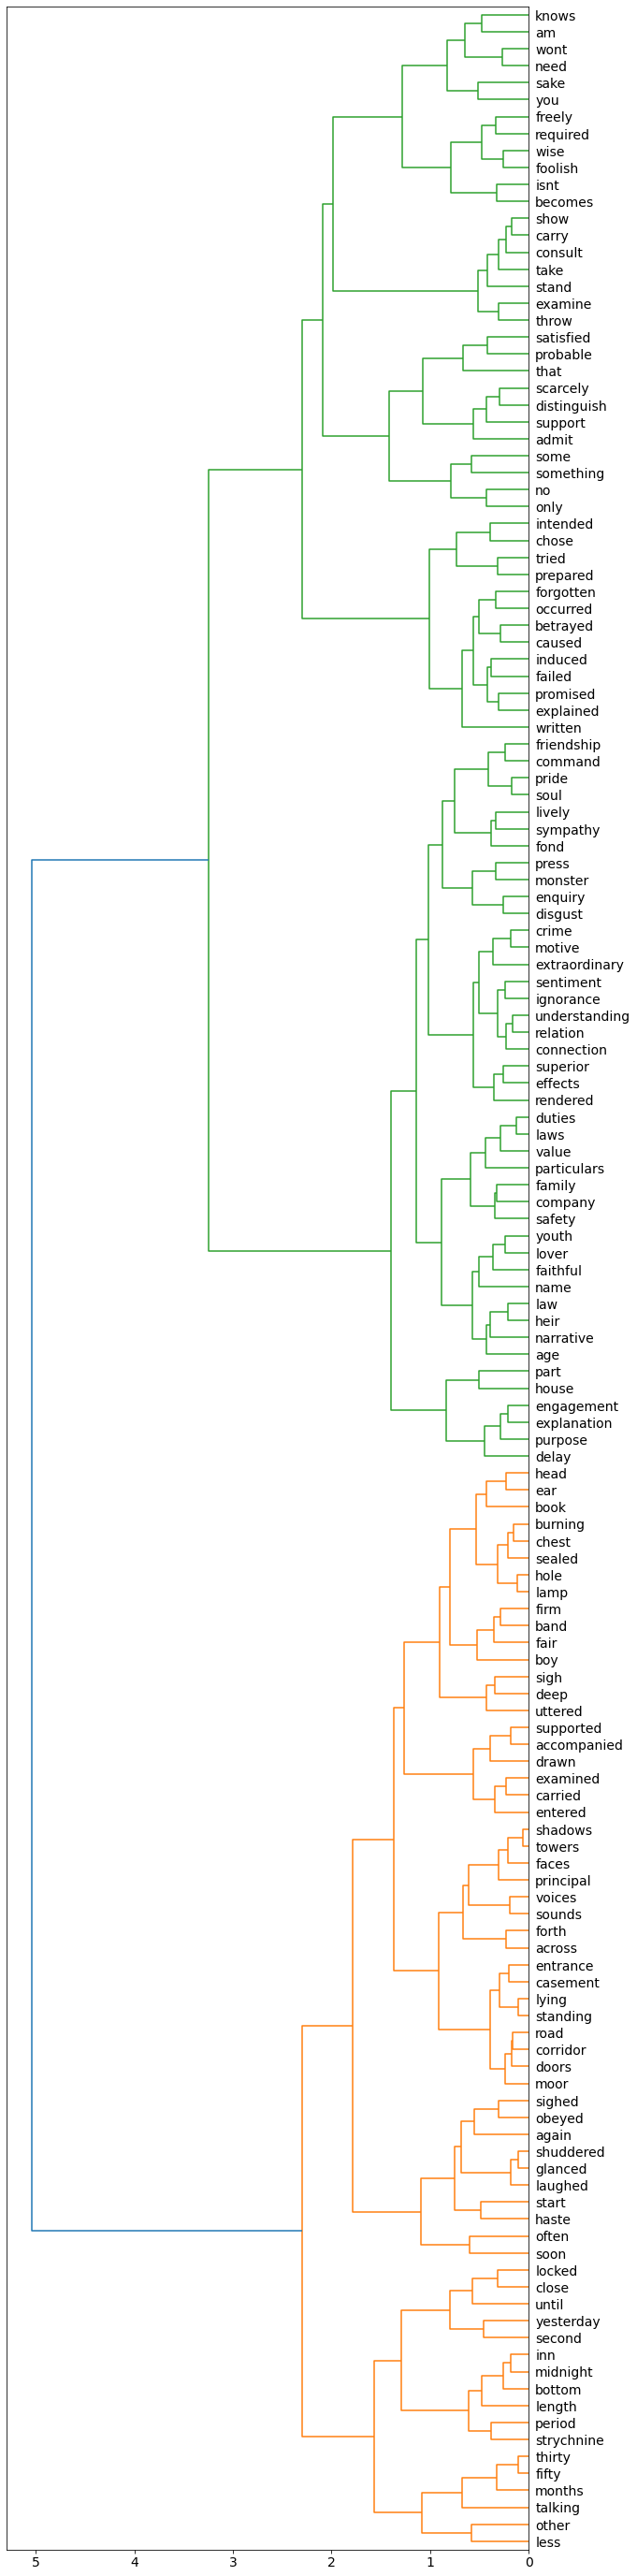

In [58]:
HAC(WV2.sample(150)).plot()

# Save

In [ ]:
# W2V = pd.DataFrame(model.wv.vectors_norm, index=model.wv.vocab.keys())
# WV.to_csv('{}/{}-W2V.csv'.format(data_out, data_prefix))
# pd.Series(DOCS).to_csv('{}/{}-GENSIM_DOCS.csv'.format(data_out, data_prefix), index=False, header=False)